# Load packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install scanpy
!pip install matplotlib==3.1.3
!pip install -U tensorflow
!pip install celltypist

import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import scipy
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import celltypist
from celltypist import models

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 12.8 MB/s 
     |████████████████████████████████| 96 kB 6.1 MB/s 
     |████████████████████████████████| 88 kB 8.6 MB/s 
     |████████████████████████████████| 11.2 MB 64.6 MB/s 
     |████████████████████████████████| 960 kB 51.0 MB/s 
     |████████████████████████████████| 1.1 MB 71.8 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=62a74bc9e3da9bd19ee89ce9d07f215eafe7d769e49c533ac52b27c1b49a0c28
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=866a151d276b325f66ec5bb1d406eadd05367205ba51519ff652c1a107064179
  Stored in directory: /root/.cache/pip/wheels/7f

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 9.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 19 kB/s 
     |████████████████████████████████| 1.7 MB 62.4 MB/s 
     |████████████████████████████████| 5.9 MB 59.6 MB/s 
     |████████████████████████████████| 438 kB 69.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5

In [2]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.3
Uninstalling matplotlib-3.5.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the pa

# Define VAE class

In [3]:
# Create weight constraint so that marker gene weights are non-negative
class BiasedNonNegative(tf.keras.constraints.Constraint):

  def __init__(self, weight_mask):
    self.marker_weight_mask = weight_mask
    self.NonMarker_weight_mask = 1 - weight_mask

# Multiply the weight matrix by weight mask
  def __call__(self, w):
    marker_sparse_w = w * self.marker_weight_mask                                                            # make marker weights sparse
    NonNeg_marker_sparse_w = marker_sparse_w * tf.cast(tf.math.greater_equal(marker_sparse_w, 0.), w.dtype)  # sparse * non-negativity constraint 
    NonMarker_sparse_w = w * self.NonMarker_weight_mask                                                      # make non-marker weights sparse
    return NonNeg_marker_sparse_w + NonMarker_sparse_w                                                       # add non-marker weights regardless of non-negativity

In [4]:
class SparseNonNegative(tf.keras.constraints.Constraint):

  def __init__(self, weight_mask):
    self.weight_mask = weight_mask

# Multiply the weight matrix by weight mask

  def __call__(self, w):
    w = w * self.weight_mask * tf.cast(tf.math.greater_equal(w, 0.), w.dtype)    # sparse * non-negative 
    return w                   

In [5]:
class BiasedVAE(Model):
    def __init__(self, num_cell_types, num_genes, reg_penalties, weight_mask):
        super(BiasedVAE, self).__init__()  
        self.reg_penalties = reg_penalties
        self.encoder_weight_mask = tf.keras.backend.constant(weight_mask) 
        self.decoder_weight_mask = tf.keras.backend.constant(weight_mask.T)
        self.mean_encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='linear', 
                      kernel_regularizer=self.encoder_marker_gene_regularizer, 
                      kernel_constraint=BiasedNonNegative(self.encoder_weight_mask)),
        ])
        self.var_encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='linear', 
                      kernel_regularizer=self.encoder_marker_gene_regularizer, 
                      kernel_constraint=BiasedNonNegative(self.encoder_weight_mask)),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(num_genes, activation='linear', 
                      kernel_regularizer=self.decoder_marker_gene_regularizer, 
                      kernel_constraint=BiasedNonNegative(self.decoder_weight_mask))
        ])

    def reparameterization(self, mean, var):
        epsilon = tf.random.normal(shape = [mean.shape[1]])             
        z = mean + (var*epsilon)                       
        return z
        
    def call(self, x):
        mean = self.mean_encoder(x)
        log_var = self.var_encoder(x)
        z = self.reparameterization(mean, tf.exp(0.5 * log_var))
        p = tf.keras.activations.softmax(z)
        decoded = self.decoder(p)
        return decoded

    def embed(self, x):
        mean = self.mean_encoder(x)
        log_var = self.var_encoder(x)
        var = tf.exp(0.5 * log_var)
        return tf.keras.activations.softmax(mean), mean, var

    def encoder_marker_gene_regularizer(self, w):
        return tf.reduce_sum(self.reg_penalties * tf.square(w))

    def decoder_marker_gene_regularizer(self, w):
        return tf.reduce_sum(self.reg_penalties.T * tf.square(w))

In [6]:
class BiasedAE(Model):
    def __init__(self, num_cell_types, num_genes, reg_penalties, weight_mask):
        super(BiasedAE, self).__init__()  
        self.reg_penalties = reg_penalties
        self.encoder_weight_mask = weight_mask 
        self.decoder_weight_mask = weight_mask.T
        self.encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='softmax', 
                      kernel_regularizer=self.encoder_marker_gene_regularizer, 
                      kernel_constraint=BiasedNonNegative(self.encoder_weight_mask)),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(num_genes, activation='linear', 
                      kernel_regularizer=self.decoder_marker_gene_regularizer, 
                      kernel_constraint=BiasedNonNegative(self.decoder_weight_mask))
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def embed(self, x):
      encoded = self.encoder(x)
      return encoded

    def encoder_marker_gene_regularizer(self, w):
      return tf.reduce_sum(self.reg_penalties * tf.square(w))

    def decoder_marker_gene_regularizer(self, w):
      return tf.reduce_sum(self.reg_penalties.T * tf.square(w))

In [7]:
class SparseVAE(Model):
    def __init__(self, num_cell_types, num_genes, weight_mask):
        super(SparseVAE, self).__init__()  
        self.encoder_weight_mask = tf.keras.backend.constant(weight_mask) 
        self.decoder_weight_mask = tf.keras.backend.constant(weight_mask.T)
        self.mean_encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='linear', 
                      kernel_constraint=SparseNonNegative(self.encoder_weight_mask)),
        ])
        self.var_encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='linear', 
                      kernel_constraint=SparseNonNegative(self.encoder_weight_mask)),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(num_genes, activation='linear', 
                      kernel_constraint=SparseNonNegative(self.decoder_weight_mask))
        ])

    def reparameterization(self, mean, var):
        epsilon = tf.random.normal(shape = [mean.shape[1]])             
        z = mean + (var*epsilon)                       
        return z
        
    def call(self, x):
        mean = self.mean_encoder(x)
        log_var = self.var_encoder(x)
        z = self.reparameterization(mean, tf.exp(0.5 * log_var))
        p = tf.keras.activations.softmax(z)
        decoded = self.decoder(p)
        return decoded

    def embed(self, x):
        mean = self.mean_encoder(x)
        log_var = self.var_encoder(x)
        var = tf.exp(0.5 * log_var)
        return tf.keras.activations.softmax(mean), mean, var

In [8]:
class SparseAE(Model):
    def __init__(self, num_cell_types, num_genes, weight_mask):
        super(SparseAE, self).__init__()  
        self.encoder_weight_mask = weight_mask 
        self.decoder_weight_mask = weight_mask.T
        self.encoder = tf.keras.Sequential([
          layers.Dense(num_cell_types, 
                       activation='softmax', 
                       kernel_constraint=SparseNonNegative(self.encoder_weight_mask))
          ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(num_genes, 
                       activation='linear', 
                       kernel_constraint = SparseNonNegative(self.decoder_weight_mask))
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def embed(self, x):
      encoded = self.encoder(x)
      return encoded

# Define t-test computation function

In [9]:
def Compute_tTest(mean1,var1,mean2,var2,n):
  tScore = (mean1-mean2) / math.sqrt((var1+var2)/n)
  DegFreedom = ((((var1**2)+(var2**2))/n)**2) / ((((var1**2)+(var2**2))/(n**2))/(n-1))
  return scipy.stats.t.sf(abs(tScore), df=DegFreedom)

# Cell Type Assignment Function

In [10]:
from numpy.ma.core import true_divide
def CellTypeAssignment(dataset, Model = "Biased VAE", LearningRate = 1e-4, pValue = 2, MarkerBias = 1, NumEpochs = 50, NumTopGenes = 10):

    # Load Panglao DB marker gene list 
    print('Cell types with marker genes available in Panglao DB: \n')
    MarkerGeneList = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/PanglaoDB_Markers.tsv",sep='\t')

    # Print expected cell type options 
    print(*list(pd.unique(MarkerGeneList['cell type'])), sep = "\n")
    print('\n')

    CellMarkers = pd.DataFrame(columns = MarkerGeneList.columns)
    PanglaoDB_list = CellMarkers['official gene symbol']
    AddCellType = "Y"
    while AddCellType == "Y":
        AddCellType = input("Add expected cell type: Y or N? ")
        while AddCellType not in ["Y","N"]:
            AddCellType = input("Add expected cell type: Y or N? ")
        if AddCellType == "Y":
            CellTypeOption = 'K'
            while CellTypeOption not in ["C", "P"]:
                CellTypeOption = input("To add custom expected cell type, type 'C'. To add expected cell type from Panglao DB, type 'P': ")
            if CellTypeOption == 'P':
                CellTypeInputRepeat = True
                while CellTypeInputRepeat == True:
                    TempCellType = input("Expected cell type: ")
                    if TempCellType not in list(pd.unique(CellMarkers['cell type'])):
                        CellTypeInputRepeat = False
                    else:
                        print("Expected cell type already inputted!")
                if TempCellType in list(pd.unique(MarkerGeneList['cell type'])): 
                    CellMarkers = CellMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == TempCellType))[0,:],:])
                else: 
                    print("The cell type inputted is not available in the Panglao DB database!")
                PanglaoDB_list = list(set(CellMarkers['official gene symbol']) & set(dataset.var_names))
                CellMarkers_list = []
                for gene in PanglaoDB_list:
                  if gene in list(CellMarkers['official gene symbol']):
                    CellMarkers_list.append({
                        'official gene symbol': gene,
                        'cell type': CellMarkers.loc[CellMarkers['official gene symbol'] == gene, 'cell type'].iloc[0]
                    })
                CellMarkers = pd.DataFrame(CellMarkers_list)
            else:
                CellTypeInputRepeat = True
                while CellTypeInputRepeat == True:
                    TempCellType = input("Expected cell type: ")
                    if TempCellType not in list(pd.unique(CellMarkers['cell type'])):
                        CellTypeInputRepeat = False
                    else:
                        print("Expected cell type already inputted!")
                CellTypeMarkerGenes = []
                KeepAdding = 'Y'
                while KeepAdding == 'Y':
                    AddMarker = input("Add marker gene: ")
                    if ((AddMarker in dataset.var_names) & (AddMarker not in CellMarkers['official gene symbol'])):
                        CellTypeMarkerGenes.append(AddMarker)
                    else:
                        print("Marker gene not available!")
                    KeepAdding = 'K'
                    while KeepAdding not in ['Y','N']:
                        KeepAdding = input("Add more markers: Y or N? ")
                CellType_df = pd.DataFrame({"official gene symbol":CellTypeMarkerGenes, 
                                            "cell type":[TempCellType]*len(CellTypeMarkerGenes)})
                PanglaoDB_list = list(set(PanglaoDB_list) & set(dataset.var_names))
                PanglaoDB_list = PanglaoDB_list + list(CellType_df['official gene symbol'])
                CellMarkers_list = []
                for gene in PanglaoDB_list:
                  if gene in list(CellMarkers['official gene symbol']):
                    CellMarkers_list.append({
                        'official gene symbol': gene,
                        'cell type': CellMarkers.loc[CellMarkers['official gene symbol'] == gene, 'cell type'].iloc[0]
                    })
                CellMarkers = pd.DataFrame(CellMarkers_list)
                CellMarkers = pd.concat([CellMarkers, CellType_df])   
    
    PanglaoDB_list = list(CellMarkers['official gene symbol'])

    print("\n")
    print(CellMarkers)
    print("\n")
    RenameCellTypes = 'Y'
    while RenameCellTypes == 'Y':
        print("Expected cell types: ")
        print(*list(pd.unique(CellMarkers['cell type'])), sep = ', ')
        print("\n")

        RenameCellTypes = 'K'
        while RenameCellTypes not in ['Y','N']:
            RenameCellTypes = input("Would you like to rename any expected cell types: Y or N? ")
            if RenameCellTypes == 'Y':
                ReplacementAvailable = 'N'
                while ReplacementAvailable == 'N':
                    ReplacedCellType = input("Expected cell type to replace: ")
                    if ReplacedCellType in list(pd.unique(CellMarkers['cell type'])):
                        ReplacementAvailable = 'Y'
                    else:
                        print('Expected cell type not available in current list!')
                Replacement = input("Replacement cell type: ")
                CellMarkers['cell type'] = CellMarkers['cell type'].replace(ReplacedCellType, Replacement)

    if Model in ["Biased AE","Biased VAE"]: 
        # Create a variable list for input genes / features 
        dataset.var['input_features'] = dataset.var['highly_variable']
        for i in range(dataset.shape[1]):
          if dataset.var_names[i] in set(PanglaoDB_list):
            dataset.var['input_features'][i] = True

        # Create anndata input for the model by filtering dataset
        dataset_input = dataset[:,dataset.var['input_features']]

    elif Model in ["Sparse AE","Sparse VAE"]:
        # Create a variable list for input genes / features 
        PanglaoDB_Input = []
        for i in range(dataset.shape[1]):
          if dataset.var_names[i] in PanglaoDB_list:
            PanglaoDB_Input.append(True)
          else: 
            PanglaoDB_Input.append(False)
        dataset.var['input_features'] = PanglaoDB_Input

        # Create anndata input for the model by filtering dataset
        dataset_input = dataset[:,dataset.var['input_features']]

    # Creating weight mask for marker genes
    input_genes = dataset_input.var_names
    cell_types = pd.unique(CellMarkers['cell type'])

    marker_gene_cell_type_weight_mask = np.zeros((len(input_genes), len(cell_types)))
    CellTypeMaskLabel = 0
    for i, gene in enumerate(input_genes):
      for j, cell_type in enumerate(cell_types):
        is_marker_gene_for_cell_type = \
          CellMarkers[(CellMarkers['official gene symbol'] == gene) & 
                          (CellMarkers['cell type'] == cell_type)].shape[0] > 0
        if is_marker_gene_for_cell_type:   # Mask = 1
          marker_gene_cell_type_weight_mask[i, j] = 1
        else:                              # Mask = 0
          marker_gene_cell_type_weight_mask[i, j] = 0

    # Creating marker gene biased regularization mask 
    marker_gene_cell_type_reg_penalties = (1 - marker_gene_cell_type_weight_mask)*MarkerBias

    # Train the model 
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    NumCellTypes = len(CellMarkers['cell type'].unique())
    num_genes = dataset_input.shape[1]
    print(Model)
    if Model == "Biased VAE": 
        autoencoder = BiasedVAE(NumCellTypes, num_genes, 
                                marker_gene_cell_type_reg_penalties,
                                marker_gene_cell_type_weight_mask)
    elif Model == "Biased AE":
        autoencoder = BiasedAE(NumCellTypes, num_genes, 
                              marker_gene_cell_type_reg_penalties,
                              marker_gene_cell_type_weight_mask)
    elif Model == "Sparse VAE":
        autoencoder = SparseVAE(NumCellTypes, num_genes, 
                              marker_gene_cell_type_weight_mask)
    elif Model == "Sparse AE":
        autoencoder = SparseAE(NumCellTypes, num_genes,
                              marker_gene_cell_type_weight_mask)
    else:
        print('ERROR: select either Biased VAE, Biased AE, Sparse VAE or Sparse AE as your model.')
        return
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LearningRate), 
                        loss=losses.MeanSquaredError())
    
    print('\n')
    print('Training the autoencoder model...')
    print('\n')

    history = autoencoder.fit(dataset_input.X, dataset_input.X,
                              epochs=NumEpochs,
                              shuffle=True,
                              validation_data=(dataset_input.X, dataset_input.X))
    
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'])
    plt.title('Training loss over epochs')
    plt.ylabel('Mean squared error')
    plt.xlabel('Epochs')
    
    # Embed the model 
    if Model in ["Biased VAE","Sparse VAE"]: 
        latent_embedding, mean, var = autoencoder.embed(dataset_input.X)
    elif Model in ["Biased AE","Sparse AE"]:
        latent_embedding = autoencoder.embed(dataset_input.X)

    # assign cell type labels based on maximum probability in the latent layer output 
    cell_type_labels = []
    for item in latent_embedding:
        cell_type_labels.append(cell_types[np.where(item == max(item))[0][0]])

    # compute pValue of each assignment and assign 'unknown' labels according p-value threshold
    if Model in ["Biased VAE","Sparse VAE"]: 
        print('\n')
        print('Calculating p-value of cell type assignments...')
        print('\n')

        NumCells = dataset_input.shape[0]
        Cell_Assignment_PValues = []
        pVal_Threshold = pValue

        for cell in range(NumCells):
            MaxIndex = tf.math.argmax(latent_embedding[cell,:]).numpy()
            pVal = []
            for LatentNode in range(NumCellTypes):
              if LatentNode != MaxIndex:
                pVal.append(Compute_tTest(mean[cell,MaxIndex],var[cell,MaxIndex],
                                          mean[cell,LatentNode],var[cell,LatentNode],
                                          num_genes))
            Cell_Assignment_PValues.append(pVal[np.argmax(pVal)])
            if pVal[np.argmax(pVal)] > pVal_Threshold:
              print('Not Confident: ' + cell_type_labels[cell] + ' = ' + str(pVal[np.argmax(pVal)]))
              cell_type_labels[cell] = 'Unknown'

        Cell_Assignment_PValues = np.array(Cell_Assignment_PValues).ravel()
        dataset.obs['pVal'] = Cell_Assignment_PValues
        dataset.obs['Predicted Cell Type'] = cell_type_labels
    else: 
        dataset.obs['Predicted Cell Type'] = cell_type_labels

    # Plot UMAP results 
    print('\n')
    print('Creating UMAP of cell type predictions...')
    print('\n')
    sc.tl.pca(dataset, use_highly_variable=False)
    # sc.tl.pca(dataset, svd_solver='arpack', use_highly_variable=False, n_comps = NumCellTypes)
    # dataset.obsm['X_pca'] = mean.numpy()
    sc.pp.neighbors(dataset)
    # sc.pp.neighbors(dataset, n_neighbors=10, n_pcs=NumCellTypes)
    sc.tl.umap(dataset)
    sc.pl.umap(dataset, color=['Predicted Cell Type'])

    # Plot gene weight activation 
    print('\n')
    print('Heatmap of Gene Activation...')
    print('\n')
    sns.heatmap(autoencoder.layers[0].get_weights()[0],
            xticklabels = cell_types,
            yticklabels = input_genes)
    plt.show()

    # Print top 10 most activated genes for each cell type assignment 
    print('\n')
    print('Most Activated Genes for Each Cell...')
    print('\n')
    i = 0 
    for cell in cell_types:
        print(cell_types[i] + ': \n')
        j = 0
        for m in input_genes[np.argsort(autoencoder.layers[0].get_weights()[0][:,i])[-NumTopGenes:]]:
            if marker_gene_cell_type_weight_mask[:,i][np.argsort(autoencoder.layers[0].get_weights()[0][:,i])[-NumTopGenes:]][j] == 0:
                print(m + ' (UNIDENTIFIED MARKER)')
            else:
                print(m)
            j += 1
        print('\n')
        i += 1 

    return dataset, autoencoder, CellMarkers

# Pancreas

In [ ]:
# Load data matrix 
Pancreas_adata = sc.read_text('/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_LogX_CellCycleRegressedOut.txt', delimiter = '\t', first_column_names=None)

# find 2000 HVGs
sc.pp.highly_variable_genes(Pancreas_adata,n_top_genes=2000)

# scale data 
sc.pp.scale(Pancreas_adata) 

# Load ground truth cell type labels 
PancreasMetadata = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/PancreasMetadata.csv")
Pancreas_adata.obs['Cell Type'] = PancreasMetadata['Cell type'].values

# Load cell barcodes 
PancreasCellID = []
for item in PancreasMetadata['Cell ID'].values:
  PancreasCellID.append(item)
Pancreas_adata.obs_names = PancreasCellID

# Load gene list 
PancreasGenes = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_Genelist.txt",header=None)
PancreasGenelist = []
for item in PancreasGenes.values.tolist():
  PancreasGenelist.append(item[0])
Pancreas_adata.var_names = PancreasGenelist

Pancreas_adata

AnnData object with n_obs × n_vars = 2209 × 26179
    obs: 'Cell Type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg'

Cell types with marker genes available in Panglao DB: 

Acinar cells
Adipocyte progenitor cells
Adipocytes
Adrenergic neurons
Airway epithelial cells
Airway goblet cells
Airway smooth muscle cells
Alpha cells
Alveolar macrophages
Anterior pituitary gland cells
Astrocytes
B cells
B cells memory
B cells naive
Basal cells
Basophils
Bergmann glia
Beta cells
Cajal-Retzius cells
Cardiac stem and precursor cells
Cardiomyocytes
Cholangiocytes
Cholinergic neurons
Chondrocytes
Choroid plexus cells
Chromaffin cells
Ciliated cells
Clara cells
Crypt cells
Decidual cells
Delta cells
Dendritic cells
Distal tubule cells
Dopaminergic neurons
Ductal cells
Embryonic stem cells
Endothelial cells
Endothelial cells (aorta)
Endothelial cells (blood brain barrier)
Enteric glia cells
Enteric neurons
Enterochromaffin cells
Enterocytes
Enteroendocrine cells
Eosinophils
Ependymal cells
Epiblast cells
Epithelial cells
Epsilon cells
Erythroblasts
Erythroid-like and erythroid precursor cells
Fibroblasts
Follicular c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Biased VAE


Training the autoencoder model...


Epoch 1/50
70/70 [==============================] - 3s 21ms/step - loss: 57.1312 - val_loss: 44.6780
Epoch 2/50
70/70 [==============================] - 1s 16ms/step - loss: 35.8699 - val_loss: 27.8456
Epoch 3/50
70/70 [==============================] - 1s 15ms/step - loss: 22.2185 - val_loss: 17.1182
Epoch 4/50
70/70 [==============================] - 1s 17ms/step - loss: 13.5877 - val_loss: 10.4127
Epoch 5/50
70/70 [==============================] - 1s 17ms/step - loss: 8.2525 - val_loss: 6.3282
Epoch 6/50
70/70 [==============================] - 1s 11ms/step - loss: 5.0454 - val_loss: 3.9149
Epoch 7/50
70/70 [==============================] - 1s 8ms/step - loss: 3.1782 - val_loss: 2.5367
Epoch 8/50
70/70 [==============================] - 1s 11ms/step - loss: 2.1288 - val_loss: 1.7782
Epoch 9/50
70/70 [==============================] - 1s 11ms/step - loss: 1.5609 - val_loss: 1.3767
Epoch 10/50
70/70 [==============================] - 

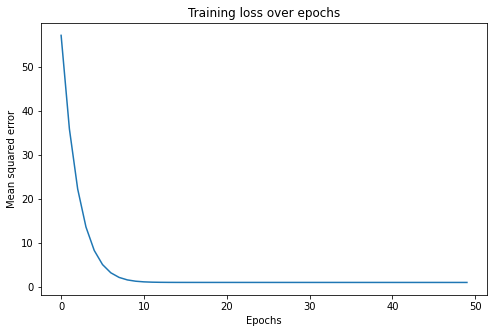

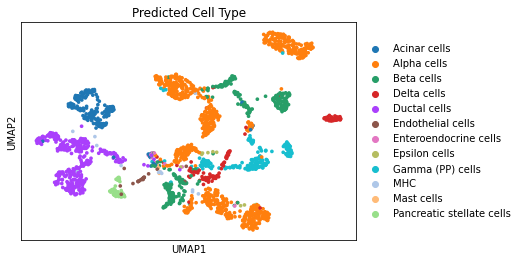



Heatmap of Gene Activation...




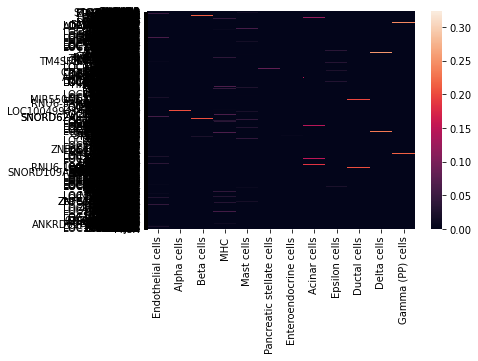



Most Activated Genes for Each Cell...


Endothelial cells: 

HYAL2
VWF
ELK3
TM4SF1
KDR
RASIP1
EPAS1
SPARCL1
SGK1
ADIRF


Alpha cells: 

SCGN
GCG
CHGA
F10
ALDH1A1
RGS4
IRX2
FAP
TTR
GC


Beta cells: 

FXYD2
BMP5
MAFA
NPTX2
G6PC2
ADCYAP1
MEG3
IAPP
PFKFB2
INS


MHC: 

HMGA1
HLA-C
HLA-DPB1
HLA-DQA1
S100A9
S100A4
BIRC3
ANXA1
ITGAM
HLA-DRB1


Mast cells: 

EXT1
HNMT
FCER1A
CXCR2
ADORA3
RAB27B
CPA3
CREB3L1
MS4A2
OAF


Pancreatic stellate cells: 

SPON2
CTGF
COL1A2
COL1A1
PDGFRA
COL4A1
COL3A1
TGFB1
TIMP3
MMP14


Enteroendocrine cells: 

TAC1
GAST
TRPA1
MLN
GAL
VEGFA
GNAT3
AFP
TAS1R3
GFRA3


Acinar cells: 

CELA3B
REG1A
CPA1
UBD
ANPEP
CTRC
RARRES2
LGALS2
RNASE1
PRSS1


Epsilon cells: 

BMP4
NPY1R
THSD4
ELOVL2
GHRL
HRH2
FAM124A
FAXDC2
GHRLOS
VTN


Ductal cells: 

CLDN1
CTSH
PDLIM3
ANXA4
ALDH1A3
TACSTD2
PERP
KRT7
LGALS4
VTCN1


Delta cells: 

UNC5B
GABRB3
BAIAP3
GHSR
FFAR4
RBP4
LEPR
HHEX
SST
BCHE


Gamma (PP) cells: 

CMTM8
CHN2
PTGFR
ABCC9
ENTPD2
SERTM1
SLITRK6
SEMA3E
THSD7A
PPY




In [ ]:
Pancreas_adata, Pancreas_VAE, PancreasMarkers = CellTypeAssignment(Pancreas_adata, 
                                                                   Model = "Biased VAE",
                                                                   LearningRate = 1e-4,
                                                                   MarkerBias = 1, 
                                                                   pValue = 2, 
                                                                   NumEpochs = 50)

In [ ]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/'
Pancreas_adata.obs.to_csv(dir + 'sparseAE_pancreas_predictions.csv')
PancreasMarkers.to_csv(dir + 'sparseAE_pancreas_markers.csv')

# GBM 

In [ ]:
# Read and process GBM data 
GBM_adata = sc.read_text("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/GBM_LogX.txt", delimiter = '\t', first_column_names=None)
GBM_adata = GBM_adata.T 

# Regress out cell cycle scores
GBMCellCycleScores = pd.read_table("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/GbmCellCycleScores.txt", delimiter = '\t')
GBM_adata.obs['score_S'] = GBMCellCycleScores['score_S'].values
GBM_adata.obs['score_G2M'] = GBMCellCycleScores['score_G2M'].values
sc.pp.regress_out(GBM_adata, ['score_S', 'score_G2M'])

# find 2000 HVGs
sc.pp.highly_variable_genes(GBM_adata,n_top_genes=2000)

# Scale (zero-center) data
sc.pp.scale(GBM_adata)

# Load ground truth cell type labels 
GBM_Metadata = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/metadata2.csv")
GBM_adata.obs['Cell Type'] = GBM_Metadata['cell_assignment'].values

# Load gene list 
GBMGenes = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/features2.tsv",header=None)
GBMGenelist = []
for item in GBMGenes.values.tolist():
  GBMGenelist.append(item[0])
GBM_adata.var_names = GBMGenelist
GBM_adata.var_names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2MP1',
       'A4GALT', 'A4GNT', 'AA06',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=23686)

Cell types with marker genes available in Panglao DB: 

Acinar cells
Adipocyte progenitor cells
Adipocytes
Adrenergic neurons
Airway epithelial cells
Airway goblet cells
Airway smooth muscle cells
Alpha cells
Alveolar macrophages
Anterior pituitary gland cells
Astrocytes
B cells
B cells memory
B cells naive
Basal cells
Basophils
Bergmann glia
Beta cells
Cajal-Retzius cells
Cardiac stem and precursor cells
Cardiomyocytes
Cholangiocytes
Cholinergic neurons
Chondrocytes
Choroid plexus cells
Chromaffin cells
Ciliated cells
Clara cells
Crypt cells
Decidual cells
Delta cells
Dendritic cells
Distal tubule cells
Dopaminergic neurons
Ductal cells
Embryonic stem cells
Endothelial cells
Endothelial cells (aorta)
Endothelial cells (blood brain barrier)
Enteric glia cells
Enteric neurons
Enterochromaffin cells
Enterocytes
Enteroendocrine cells
Eosinophils
Ependymal cells
Epiblast cells
Epithelial cells
Epsilon cells
Erythroblasts
Erythroid-like and erythroid precursor cells
Fibroblasts
Follicular c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Biased VAE


Training the autoencoder model...


Epoch 1/100
248/248 [==============================] - 3s 9ms/step - loss: 2.3594 - val_loss: 0.9965
Epoch 2/100
248/248 [==============================] - 2s 7ms/step - loss: 0.9951 - val_loss: 0.9934
Epoch 3/100
248/248 [==============================] - 1s 5ms/step - loss: 0.9924 - val_loss: 0.9909
Epoch 4/100
248/248 [==============================] - 2s 6ms/step - loss: 0.9900 - val_loss: 0.9888
Epoch 5/100
248/248 [==============================] - 2s 6ms/step - loss: 0.9880 - val_loss: 0.9870
Epoch 6/100
248/248 [==============================] - 1s 6ms/step - loss: 0.9862 - val_loss: 0.9853
Epoch 7/100
248/248 [==============================] - 2s 6ms/step - loss: 0.9847 - val_loss: 0.9840
Epoch 8/100
248/248 [==============================] - 1s 5ms/step - loss: 0.9834 - val_loss: 0.9829
Epoch 9/100
248/248 [==============================] - 1s 5ms/step - loss: 0.9822 - val_loss: 0.9815
Epoch 10/100
248/248 [====================

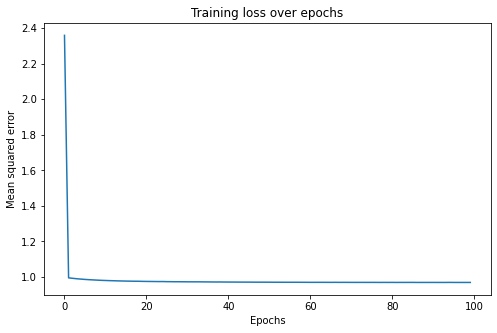

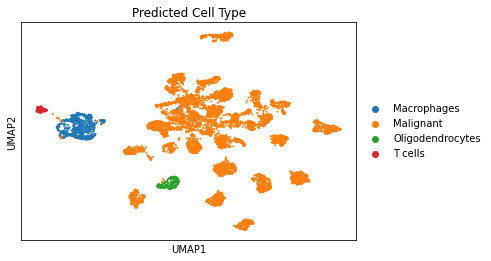



Heatmap of Gene Activation...




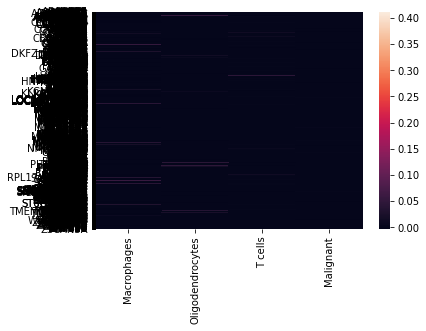



Most Activated Genes for Each Cell...


Macrophages: 

CXCL16
CD68
CPM
VSIG4
MS4A4A
CD83
SEPP1
NR4A3
CD74
CD3E


Oligodendrocytes: 

ARRDC2
ASPA
BCAS1
MBP
SEMA4D
ANLN
OMG
PLEKHH1
SOX10
PLP1


T cells: 

CCL4
GIMAP5
CD3G
CD247
LCK
CD2
IL32
SH2D1A
CXCR4
CD4


Malignant: 

MIR548H4 (UNIDENTIFIED MARKER)
MIR5088 (UNIDENTIFIED MARKER)
CD33
IDH2
RB1
PIK3CA
MIR4641 (UNIDENTIFIED MARKER)
ATRX
TP53
IDH1




In [ ]:
GBM_adata, GBM_VAE, GBM_Markers = CellTypeAssignment(GBM_adata,
                                                     Model = "Biased VAE", 
                                                     LearningRate = 1e-3, 
                                                     MarkerBias = 1,
                                                     pValue = 2, 
                                                     NumEpochs = 100)

In [ ]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/'
GBM_adata.obs.to_csv(dir + 'sparseAE_GBM_predictions.csv')
GBM_Markers.to_csv(dir + 'sparseAE_GBM_markers.csv')

# PBMC

In [ ]:
# Pre-processing in R: log2(X+1) > regress out cell cycle score > scale  

PBMC_adata_original = sc.read_text("/content/drive/MyDrive/ML for genomics project group /Data/PBMC Data/matrix.txt", delimiter = '\t', first_column_names=None)
PBMC_adata_original = PBMC_adata_original.T

# Load gene list 
PBMC_Genes = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/PBMC Data/features.txt")
PBMC_Genelist = []
for item in PBMC_Genes.values:
  PBMC_Genelist.append(item[0])
PBMC_adata_original.var_names = PBMC_Genelist

PBMC_Truth = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/PBMC Data/Ground_Truth_PBMC3k.csv")
PBMC_adata_original.obs['Cell Type'] = PBMC_Truth['orig_id'].values

PBMC_adata_original

AnnData object with n_obs × n_vars = 2467 × 13714
    obs: 'Cell Type'

In [ ]:
# Data processing for CellTypist
PBMC_adata = PBMC_adata_original
UnitNormalized_X = (PBMC_adata.X - np.amin(PBMC_adata.X)) / (np.amax(PBMC_adata.X) - np.amin(PBMC_adata.X))
PBMC_adata.X = UnitNormalized_X 

sc.pp.normalize_total(PBMC_adata, target_sum=10000)
sc.pp.log1p(PBMC_adata)
PBMC_adata.X = scipy.sparse.csr_matrix(PBMC_adata.X)
PBMC_adata.X.expm1().sum(axis = 1)

PBMC_adata.raw = PBMC_adata
PBMC_adata

AnnData object with n_obs × n_vars = 2467 × 13714
    obs: 'Cell Type'
    uns: 'log1p'

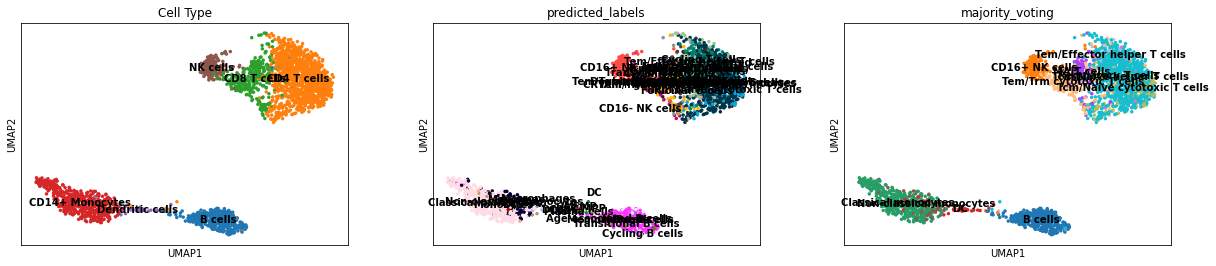

In [ ]:
# Run CellTypist
models.download_models(force_update = True)
models.models_path
model = models.Model.load(model = 'Immune_All_Low.pkl')

predictions = celltypist.annotate(PBMC_adata, model = 'Immune_All_Low.pkl', majority_voting = True)
adata = predictions.to_adata()

sc.pp.pca(adata, use_highly_variable=False)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['Cell Type', 'predicted_labels', 'majority_voting'], legend_loc = 'on data')

In [ ]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/PBMC Data/'
adata.obs.to_csv(dir + 'CellTypist_PBMC_predictions.csv')

Cell types with marker genes available in Panglao DB: 

Acinar cells
Adipocyte progenitor cells
Adipocytes
Adrenergic neurons
Airway epithelial cells
Airway goblet cells
Airway smooth muscle cells
Alpha cells
Alveolar macrophages
Anterior pituitary gland cells
Astrocytes
B cells
B cells memory
B cells naive
Basal cells
Basophils
Bergmann glia
Beta cells
Cajal-Retzius cells
Cardiac stem and precursor cells
Cardiomyocytes
Cholangiocytes
Cholinergic neurons
Chondrocytes
Choroid plexus cells
Chromaffin cells
Ciliated cells
Clara cells
Crypt cells
Decidual cells
Delta cells
Dendritic cells
Distal tubule cells
Dopaminergic neurons
Ductal cells
Embryonic stem cells
Endothelial cells
Endothelial cells (aorta)
Endothelial cells (blood brain barrier)
Enteric glia cells
Enteric neurons
Enterochromaffin cells
Enterocytes
Enteroendocrine cells
Eosinophils
Ependymal cells
Epiblast cells
Epithelial cells
Epsilon cells
Erythroblasts
Erythroid-like and erythroid precursor cells
Fibroblasts
Follicular c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Biased VAE


Training the autoencoder model...


Epoch 1/100
78/78 [==============================] - 1s 9ms/step - loss: 14.1405 - val_loss: 0.4604
Epoch 2/100
78/78 [==============================] - 0s 5ms/step - loss: 0.3990 - val_loss: 0.3844
Epoch 3/100
78/78 [==============================] - 0s 5ms/step - loss: 0.3772 - val_loss: 0.3699
Epoch 4/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3640 - val_loss: 0.3579
Epoch 5/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3528 - val_loss: 0.3477
Epoch 6/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3433 - val_loss: 0.3388
Epoch 7/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3351 - val_loss: 0.3312
Epoch 8/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3278 - val_loss: 0.3244
Epoch 9/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3215 - val_loss: 0.3184
Epoch 10/100
78/78 [==============================] - 0s 6m

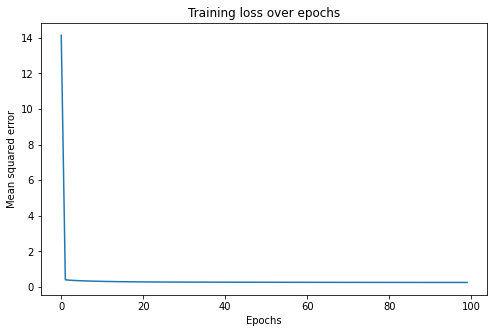

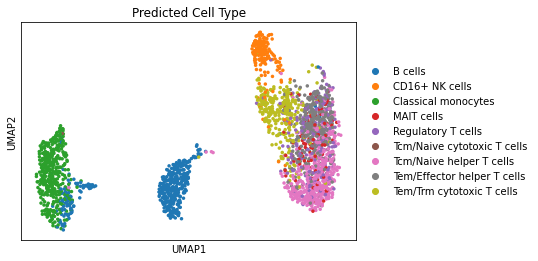



Heatmap of Gene Activation...




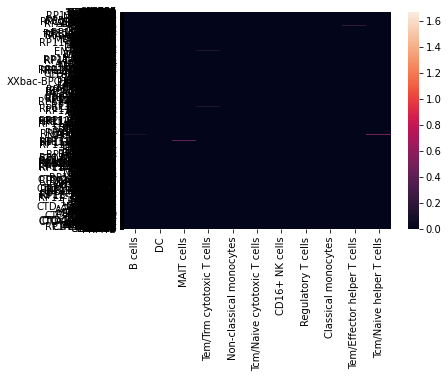



Most Activated Genes for Each Cell...


B cells: 

RUNDC1 (UNIDENTIFIED MARKER)
CD19
CD79A
MALAT1
MS4A1
PTMA
HBA1
CD74
HLA-DRB1
HLA-DRA


DC: 

RP11-589C21.6 (UNIDENTIFIED MARKER)
CDKN2A (UNIDENTIFIED MARKER)
PDXDC1 (UNIDENTIFIED MARKER)
RARA (UNIDENTIFIED MARKER)
LAMP2 (UNIDENTIFIED MARKER)
CLEC10A
GPX1
CD1C
RGS1
FCER1A


MAIT cells: 

ARL6IP5 (UNIDENTIFIED MARKER)
SRGN (UNIDENTIFIED MARKER)
LIMD2 (UNIDENTIFIED MARKER)
OAZ1 (UNIDENTIFIED MARKER)
UBB (UNIDENTIFIED MARKER)
S100A6 (UNIDENTIFIED MARKER)
CD74 (UNIDENTIFIED MARKER)
KLRG1
KLRB1
IL7R


Tem/Trm cytotoxic T cells: 

CDC42EP3 (UNIDENTIFIED MARKER)
YBX3
SH2D1A
CMC1
CD8A
CD8B
CST7
GZMK
GZMA
CCL5


Non-classical monocytes: 

GLB1 (UNIDENTIFIED MARKER)
PRKCD (UNIDENTIFIED MARKER)
TMEM91 (UNIDENTIFIED MARKER)
STX4 (UNIDENTIFIED MARKER)
TASP1 (UNIDENTIFIED MARKER)
ANKRD34B (UNIDENTIFIED MARKER)
CRIP3 (UNIDENTIFIED MARKER)
FBXO33 (UNIDENTIFIED MARKER)
CAPN12 (UNIDENTIFIED MARKER)
C16orf52 (UNIDENTIFIED MARKER)


Tcm/Naive cytotoxic T

In [ ]:
# Run VAE model
sc.pp.highly_variable_genes(PBMC_adata_original)
PBMC_adata = PBMC_adata_original

PBMC_adata, PBMC_VAE, PBMC_Markers = CellTypeAssignment(PBMC_adata, 
                                                        Model = "Biased VAE",
                                                        LearningRate = 1e-3, 
                                                        MarkerBias = 1,
                                                        pValue = 2, 
                                                        NumEpochs = 100)

Cell type labels: 
- CD16+ NK cells
- B cells
- DC
- Classical monocytes
- Non-classical monocytes
- Regulatory T cells 
- Tem/Trm cytotoxic T cells 
- Tcm/Naive cytotoxic T cells 
- MAIT cells 
- Tem/Effector helper T cells 
- Tcm/Naive helper T cells 

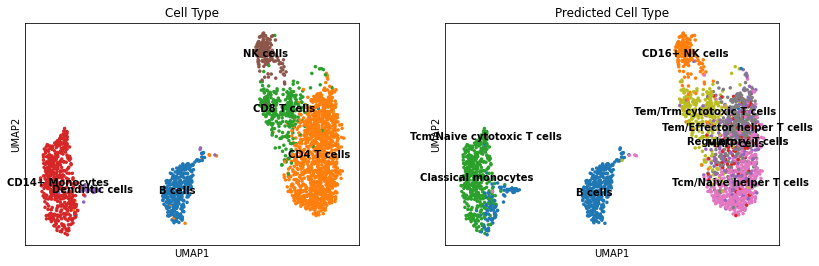

In [ ]:
sc.pl.umap(PBMC_adata, 
           color=['Cell Type','Predicted Cell Type'],
           legend_loc = 'on data')

In [ ]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/PBMC Data/'
PBMC_adata.obs.to_csv(dir + 'biasedVAE_PBMC_predictions.csv')
PBMC_Markers.to_csv(dir + 'biasedVAE_PBMC_markers.csv')

# CellTypist Immune Cells

In [ ]:
adata_2000 = sc.read('celltypist_demo_folder/demo_2000_cells.h5ad', 
                     backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_2000_cells.h5ad')

  0%|          | 0.00/34.1M [00:00<?, ?B/s]

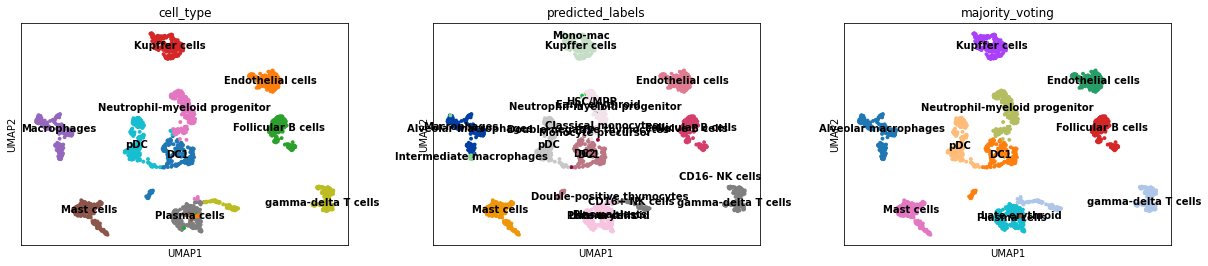

In [ ]:
models.download_models(force_update = True)
models.models_path
model = models.Model.load(model = 'Immune_All_Low.pkl')

predictions = celltypist.annotate(adata_2000, model = 'Immune_All_Low.pkl', majority_voting = True)
adata_2000 = predictions.to_adata()

sc.pp.pca(adata_2000, use_highly_variable=False)
sc.pp.neighbors(adata_2000)
sc.tl.umap(adata_2000)
sc.pl.umap(adata_2000, color = ['cell_type', 'predicted_labels', 'majority_voting'], legend_loc = 'on data')

In [ ]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/CellTypist Data/'
adata_2000.obs.to_csv(dir + 'CellTypist_CTdata_predictions.csv')

In [ ]:
adata_2000 = sc.read('celltypist_demo_folder/demo_2000_cells.h5ad', 
                     backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_2000_cells.h5ad')
adata_2000.X = adata_2000.X.toarray()

# Regress out cell cycle scores
CT_CellCycleScores = pd.read_table("/content/drive/MyDrive/ML for genomics project group /Data/CellTypist Data/CellCycleScore.csv",
                                   delimiter=',')
adata_2000.obs['score_S'] = CT_CellCycleScores['score_S'].values
adata_2000.obs['score_G2M'] = CT_CellCycleScores['score_G2M'].values
sc.pp.regress_out(adata_2000, ['score_S', 'score_G2M'])

# Find 2000 HVGs
sc.pp.highly_variable_genes(adata_2000)

# Scale (zero-center) data
sc.pp.scale(adata_2000)

adata_2000

AnnData object with n_obs × n_vars = 2000 × 18950
    obs: 'cell_type', 'score_S', 'score_G2M'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg'

Cell types with marker genes available in Panglao DB: 

Acinar cells
Adipocyte progenitor cells
Adipocytes
Adrenergic neurons
Airway epithelial cells
Airway goblet cells
Airway smooth muscle cells
Alpha cells
Alveolar macrophages
Anterior pituitary gland cells
Astrocytes
B cells
B cells memory
B cells naive
Basal cells
Basophils
Bergmann glia
Beta cells
Cajal-Retzius cells
Cardiac stem and precursor cells
Cardiomyocytes
Cholangiocytes
Cholinergic neurons
Chondrocytes
Choroid plexus cells
Chromaffin cells
Ciliated cells
Clara cells
Crypt cells
Decidual cells
Delta cells
Dendritic cells
Distal tubule cells
Dopaminergic neurons
Ductal cells
Embryonic stem cells
Endothelial cells
Endothelial cells (aorta)
Endothelial cells (blood brain barrier)
Enteric glia cells
Enteric neurons
Enterochromaffin cells
Enterocytes
Enteroendocrine cells
Eosinophils
Ependymal cells
Epiblast cells
Epithelial cells
Epsilon cells
Erythroblasts
Erythroid-like and erythroid precursor cells
Fibroblasts
Follicular c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Biased VAE


Training the autoencoder model...


Epoch 1/100
63/63 [==============================] - 1s 9ms/step - loss: 16.3389 - val_loss: 1.3524
Epoch 2/100
63/63 [==============================] - 0s 6ms/step - loss: 1.0467 - val_loss: 0.9992
Epoch 3/100
63/63 [==============================] - 0s 7ms/step - loss: 0.9988 - val_loss: 0.9983
Epoch 4/100
63/63 [==============================] - 0s 6ms/step - loss: 0.9981 - val_loss: 0.9976
Epoch 5/100
63/63 [==============================] - 0s 6ms/step - loss: 0.9973 - val_loss: 0.9967
Epoch 6/100
63/63 [==============================] - 0s 6ms/step - loss: 0.9965 - val_loss: 0.9960
Epoch 7/100
63/63 [==============================] - 0s 6ms/step - loss: 0.9957 - val_loss: 0.9952
Epoch 8/100
63/63 [==============================] - 0s 6ms/step - loss: 0.9950 - val_loss: 0.9946
Epoch 9/100
63/63 [==============================] - 0s 6ms/step - loss: 0.9944 - val_loss: 0.9940
Epoch 10/100
63/63 [==============================] - 0s 6m

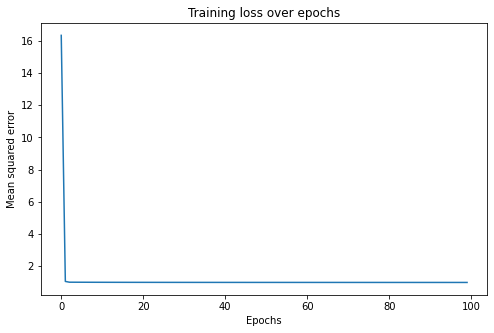

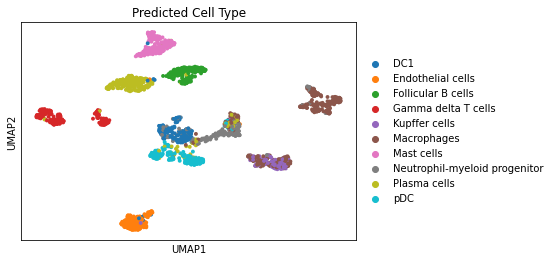



Heatmap of Gene Activation...




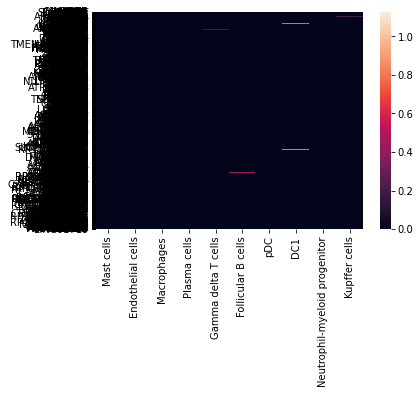



Most Activated Genes for Each Cell...


Mast cells: 

MOSPD1 (UNIDENTIFIED MARKER)
DEFA6 (UNIDENTIFIED MARKER)
MIR29B2CHG (UNIDENTIFIED MARKER)
RP11-640M9.1 (UNIDENTIFIED MARKER)
PKD1 (UNIDENTIFIED MARKER)
POMZP3 (UNIDENTIFIED MARKER)
SIGLEC6
TPSB2
TPSAB1
CPA3


Endothelial cells: 

KRT6A (UNIDENTIFIED MARKER)
STC1 (UNIDENTIFIED MARKER)
IGFBP3 (UNIDENTIFIED MARKER)
SPARCL1
MEOX2
CLDN5
CFI
PLVAP
ACKR1
RAMP3


Macrophages: 

PTPRC
RNASE1
APOC1
TREM2
FTL
APOE
C1QB
C1QA
CD68
AIF1


Plasma cells: 

MIR29B2CHG (UNIDENTIFIED MARKER)
SNHG16 (UNIDENTIFIED MARKER)
IGLV1-47 (UNIDENTIFIED MARKER)
SENP3 (UNIDENTIFIED MARKER)
POMZP3 (UNIDENTIFIED MARKER)
MAG
XBP1
IGKC
MZB1
JCHAIN


Gamma delta T cells: 

ORAI2 (UNIDENTIFIED MARKER)
FCRL4
TRGV8
CDH17
KLHL23
TRGC1
KIR2DL4
KLRC2
CCL5
TRDC


Follicular B cells: 

CACTIN (UNIDENTIFIED MARKER)
TSTD3 (UNIDENTIFIED MARKER)
EPS8L1 (UNIDENTIFIED MARKER)
CXCR5
CD22
RPL41
GAS5
TNFRSF13B
MT-RNR2
IGHA1


pDC: 

OXNAD1 (UNIDENTIFIED MARKER)
KIAA1841 (UNIDENTIFIE

In [ ]:
adata_2000, CT_VAE, CT_Markers = CellTypeAssignment(adata_2000, 
                                                    Model = "Biased VAE",
                                                    LearningRate = 1e-3, 
                                                    MarkerBias = 1,
                                                    pValue = 2, 
                                                    NumEpochs = 100)

Cell Types
- Gamma delta T cells
- Mast cells 
- Endothelial cells
- pDC 
- Plasma cells 
- Follicular B cells 
- Neutrophil-myeloid progenitor 
- DC1 
- Macrophages 
- Kupffer cells

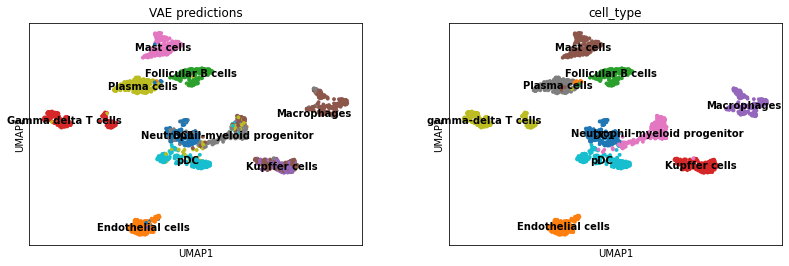

In [ ]:
adata_2000.obs['VAE predictions'] = adata_2000.obs['Predicted Cell Type'].values
sc.pl.umap(adata_2000, color = ['VAE predictions','cell_type'], legend_loc = 'on data')

In [ ]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/CellTypist Data/'
adata_2000.obs.to_csv(dir + 'biasedVAE_CTdata_predictions.csv')
CT_Markers.to_csv(dir + 'biasedVAE_CTdata_markers.csv')

# Follicular Lymphoma

In [11]:
SceFollicula_original = sc.read_h5ad("/content/drive/MyDrive/ML for genomics project group /Data/CellAssign Data /Source Data/sce_follicular_annotated_final.h5ad")
SceFollicula_original

AnnData object with n_obs × n_vars = 9156 × 33694
    obs: 'Sample', 'dataset', 'patient', 'timepoint', 'progression_status', 'patient_progression', 'sample_barcode', 'is_cell_control', 'total_features_by_counts', 'log10_total_features_by_counts', 'total_counts', 'log10_total_counts', 'pct_counts_in_top_50_features', 'pct_counts_in_top_100_features', 'pct_counts_in_top_200_features', 'pct_counts_in_top_500_features', 'total_features_by_counts_endogenous', 'log10_total_features_by_counts_endogenous', 'total_counts_endogenous', 'log10_total_counts_endogenous', 'pct_counts_endogenous', 'pct_counts_in_top_50_features_endogenous', 'pct_counts_in_top_100_features_endogenous', 'pct_counts_in_top_200_features_endogenous', 'pct_counts_in_top_500_features_endogenous', 'total_features_by_counts_feature_control', 'log10_total_features_by_counts_feature_control', 'total_counts_feature_control', 'log10_total_counts_feature_control', 'pct_counts_feature_control', 'pct_counts_in_top_50_features_featur

In [12]:
SceFollicula_adata = sc.read_h5ad("/content/drive/MyDrive/ML for genomics project group /Data/CellAssign Data /Source Data/sce_follicular_annotated_final.h5ad")

# Subsetting the cell barcodes 
SceFollicula_adata.obs = SceFollicula_adata.obs[['Sample']]
SceFollicula_adata.obs.drop(['Sample'], axis=1, inplace=True)

# Subsetting the gene name IDs 
SceFollicula_adata.var = SceFollicula_adata.var[['ID']]
SceFollicula_adata.var.set_index('ID', inplace=True)

# Load gene list 
FollicularLymphomaGenes = pd.read_table("/content/drive/MyDrive/ML for genomics project group /Data/CellAssign Data /Gene_Name.txt")
FollicularLymphomaGenelist = []
for item in FollicularLymphomaGenes.values.tolist():
  FollicularLymphomaGenelist.append(item[0])
SceFollicula_adata.var_names = FollicularLymphomaGenelist

# Load ground truth cell type labels 
SceFollicula_GroundTruth = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/CellAssign Data /GroundTruth_FollicularLymphoma.csv")
SceFollicula_adata.obs['Cell Type'] = SceFollicula_GroundTruth['x'].values

# Patient annotaion
SceFollicula_adata.obs['Patient'] = SceFollicula_original.obs['patient'].values

# Timepoint annotation 
SceFollicula_adata.obs['Timepoint'] = SceFollicula_original.obs['timepoint'].values

SceFollicula_adata

AnnData object with n_obs × n_vars = 9156 × 33694
    obs: 'Cell Type', 'Patient'
    uns: 'log.exprs.offset'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'logcounts'

In [13]:
# Pre-process: log1p > regress out cell cycle score > HVG > scale
sc.pp.log1p(SceFollicula_adata)

# Regress out cell cycle scores
FL_CellCycleScores = pd.read_table("/content/drive/MyDrive/ML for genomics project group /Data/CellAssign Data /CellCycleScore.csv", delimiter = ',')
SceFollicula_adata.obs['score_S'] = FL_CellCycleScores['score_S'].values
SceFollicula_adata.obs['score_G2M'] = FL_CellCycleScores['score_G2M'].values
sc.pp.regress_out(SceFollicula_adata, ['score_S', 'score_G2M'])

sc.pp.highly_variable_genes(SceFollicula_adata)
sc.pp.scale(SceFollicula_adata)
SceFollicula_adata

AnnData object with n_obs × n_vars = 9156 × 33694
    obs: 'Cell Type', 'Patient', 'score_S', 'score_G2M'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log.exprs.offset', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'logcounts'

Cell types with marker genes available in Panglao DB: 

Acinar cells
Adipocyte progenitor cells
Adipocytes
Adrenergic neurons
Airway epithelial cells
Airway goblet cells
Airway smooth muscle cells
Alpha cells
Alveolar macrophages
Anterior pituitary gland cells
Astrocytes
B cells
B cells memory
B cells naive
Basal cells
Basophils
Bergmann glia
Beta cells
Cajal-Retzius cells
Cardiac stem and precursor cells
Cardiomyocytes
Cholangiocytes
Cholinergic neurons
Chondrocytes
Choroid plexus cells
Chromaffin cells
Ciliated cells
Clara cells
Crypt cells
Decidual cells
Delta cells
Dendritic cells
Distal tubule cells
Dopaminergic neurons
Ductal cells
Embryonic stem cells
Endothelial cells
Endothelial cells (aorta)
Endothelial cells (blood brain barrier)
Enteric glia cells
Enteric neurons
Enterochromaffin cells
Enterocytes
Enteroendocrine cells
Eosinophils
Ependymal cells
Epiblast cells
Epithelial cells
Epsilon cells
Erythroblasts
Erythroid-like and erythroid precursor cells
Fibroblasts
Follicular c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Biased VAE


Training the autoencoder model...


Epoch 1/50
287/287 [==============================] - 4s 6ms/step - loss: 7.8107 - val_loss: 4.8402
Epoch 2/50
287/287 [==============================] - 1s 4ms/step - loss: 3.3055 - val_loss: 2.1971
Epoch 3/50
287/287 [==============================] - 1s 3ms/step - loss: 1.6692 - val_loss: 1.3072
Epoch 4/50
287/287 [==============================] - 1s 3ms/step - loss: 1.1552 - val_loss: 1.0578
Epoch 5/50
287/287 [==============================] - 1s 3ms/step - loss: 1.0229 - val_loss: 1.0023
Epoch 6/50
287/287 [==============================] - 1s 5ms/step - loss: 0.9960 - val_loss: 0.9925
Epoch 7/50
287/287 [==============================] - 1s 3ms/step - loss: 0.9915 - val_loss: 0.9909
Epoch 8/50
287/287 [==============================] - 1s 3ms/step - loss: 0.9905 - val_loss: 0.9902
Epoch 9/50
287/287 [==============================] - 1s 4ms/step - loss: 0.9900 - val_loss: 0.9897
Epoch 10/50
287/287 [==============================

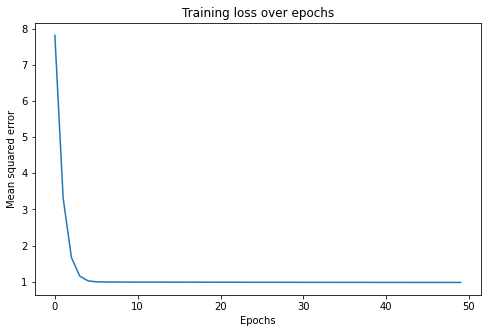

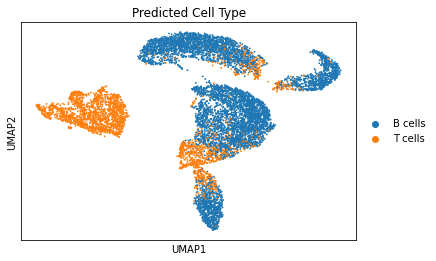



Heatmap of Gene Activation...




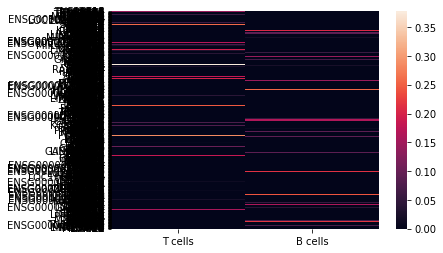



Most Activated Genes for Each Cell...


T cells: 

S100A4
TRBC1
CD4
CD3G
CD2
CD3D
CD3E
IL32
SYT3
CYTL1


B cells: 

FCRLA
CD22
CD79B
MS4A1
HLA-DQA1
IGLC3
CD74
IGLC2
HLA-DRA
CD79A




In [16]:
SceFollicula_adata, SceFollicula_VAE, SceFolliculaMarkers = CellTypeAssignment(SceFollicula_adata, 
                                                                   Model = "Biased VAE",
                                                                   LearningRate = 1e-4,
                                                                   MarkerBias = 1, 
                                                                   pValue = 2, 
                                                                   NumEpochs = 50)

Cell Types: 
- B cells (CT)
- CD4 T cells (CA)
- Cytotoxic T cells (CA)
- Follicular helper T cells (CT)
- Other

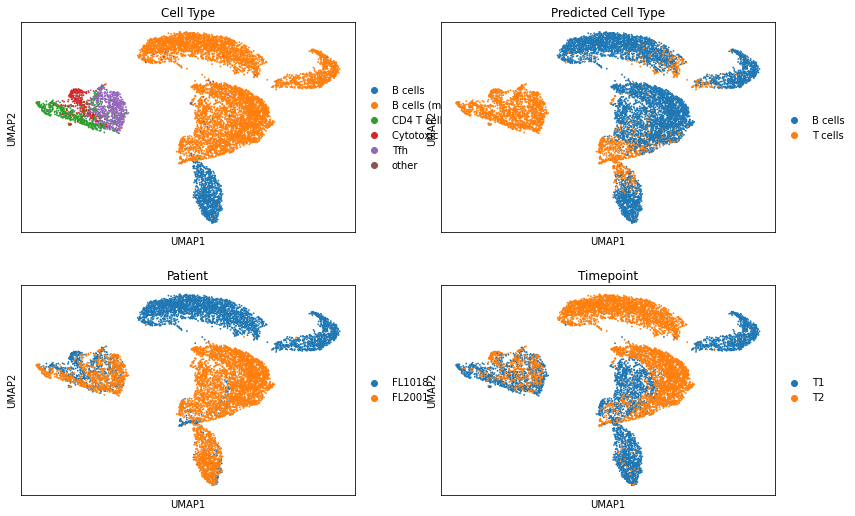

In [19]:
sc.pl.umap(SceFollicula_adata,
           color = ['Cell Type', 
                    'Predicted Cell Type', 
                    'Patient',
                    'Timepoint'],
           ncols = 2)

In [ ]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/CellAssign Data /'
SceFollicula_adata.obs.to_csv(dir + 'biasedVAE_FollicularLymphoma_predictions.csv')
SceFolliculaMarkers.to_csv(dir + 'biasedVAE_FollicularLymphoma_markers.csv')

# CellAssign Implementation

In [ ]:
# CellAssign implementation 
# https://docs.scvi-tools.org/en/stable/tutorials/notebooks/cellassign_tutorial.html

!pip install --quiet scvi-colab
from scvi_colab import install
install()

     |████████████████████████████████| 235 kB 7.2 MB/s 
     |████████████████████████████████| 51 kB 4.8 MB/s 
INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [ ]:
!pip install gdown

import gdown
url = 'https://drive.google.com/uc?id=10l6m2KKKioCZnQlRHomheappHh-jTFmx'
output = 'sce_follicular_annotated_final.h5ad'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1Pae7VEcoZbKRvtllGAEWG4SOLWSjjtCO'
output = 'sce_hgsc_annotated_final.h5ad'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1Mk5uPdnPC4IMRnuG5N4uFvypT8hPdJ74'
output = 'HGSC_celltype.csv'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1tJSOI9ve0i78WmszMLx2ul8F8tGycBTd'
output = 'FL_celltype.csv'
gdown.download(url, output, quiet=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From: https://drive.google.com/uc?id=10l6m2KKKioCZnQlRHomheappHh-jTFmx
To: /content/sce_follicular_annotated_final.h5ad
100%|██████████| 83.0M/83.0M [00:00<00:00, 99.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Pae7VEcoZbKRvtllGAEWG4SOLWSjjtCO
To: /content/sce_hgsc_annotated_final.h5ad
100%|██████████| 110M/110M [00:00<00:00, 138MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Mk5uPdnPC4IMRnuG5N4uFvypT8hPdJ74
To: /content/HGSC_celltype.csv
100%|██████████| 1.16k/1.16k [00:00<00:00, 2.83MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tJSOI9ve0i78WmszMLx2ul8F8tGycBTd
To: /content/FL_celltype.csv
100%|██████████| 446/446 [00:00<00:00, 873kB/s]


'FL_celltype.csv'

In [ ]:
import scvi

sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [ ]:
adata = sc.read("/content/drive/MyDrive/ML for genomics project group /Data/CellAssign Data /Source Data/sce_follicular_annotated_final.h5ad")
adata.var_names_make_unique()
adata.obs_names_make_unique()

marker_gene_mat = pd.read_csv('/content/drive/MyDrive/ML for genomics project group /Data/CellAssign Data /Source Data/FL_celltype.csv', 
                              index_col=0)

bdata = adata[:, marker_gene_mat.index].copy()

lib_size = adata.X.sum(1)
adata.obs["size_factor"] = lib_size / np.mean(lib_size)

scvi.external.CellAssign.setup_anndata(bdata, size_factor_key="size_factor")

from scvi.external import CellAssign
model = CellAssign(bdata, marker_gene_mat)
model.train()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:259: LightningDeprecationWarning: The `Callback.on_batch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_train_batch_end` instead.
  f"The `Callback.{hook}` hook was deprecated in v1.6 and"


Epoch 400/400: 100%|██████████| 400/400 [06:37<00:00,  1.01it/s, loss=19.9, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:37<00:00,  1.01it/s, loss=19.9, v_num=1]


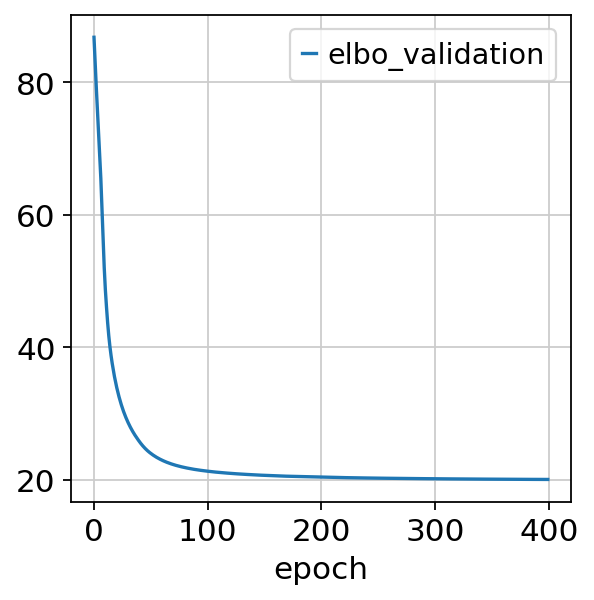

In [ ]:
model.history["elbo_validation"].plot()

In [ ]:
predictions = model.predict()
predictions.head()

,B cells,Cytotoxic T cells,CD4 T cells,Tfh,other
0,1.000000e+00,1.739434e-19,7.751767e-16,1.869602e-17,4.378880e-15
1,1.000000e+00,2.178876e-21,9.382422e-18,1.186503e-19,7.339117e-17
2,1.000000e+00,1.889336e-26,1.200274e-22,1.176637e-24,1.285320e-21
3,1.000000e+00,3.226796e-44,1.242665e-37,2.663804e-40,3.492030e-34
4,3.411848e-17,7.348489e-13,9.995215e-01,4.784879e-04,2.219961e-18


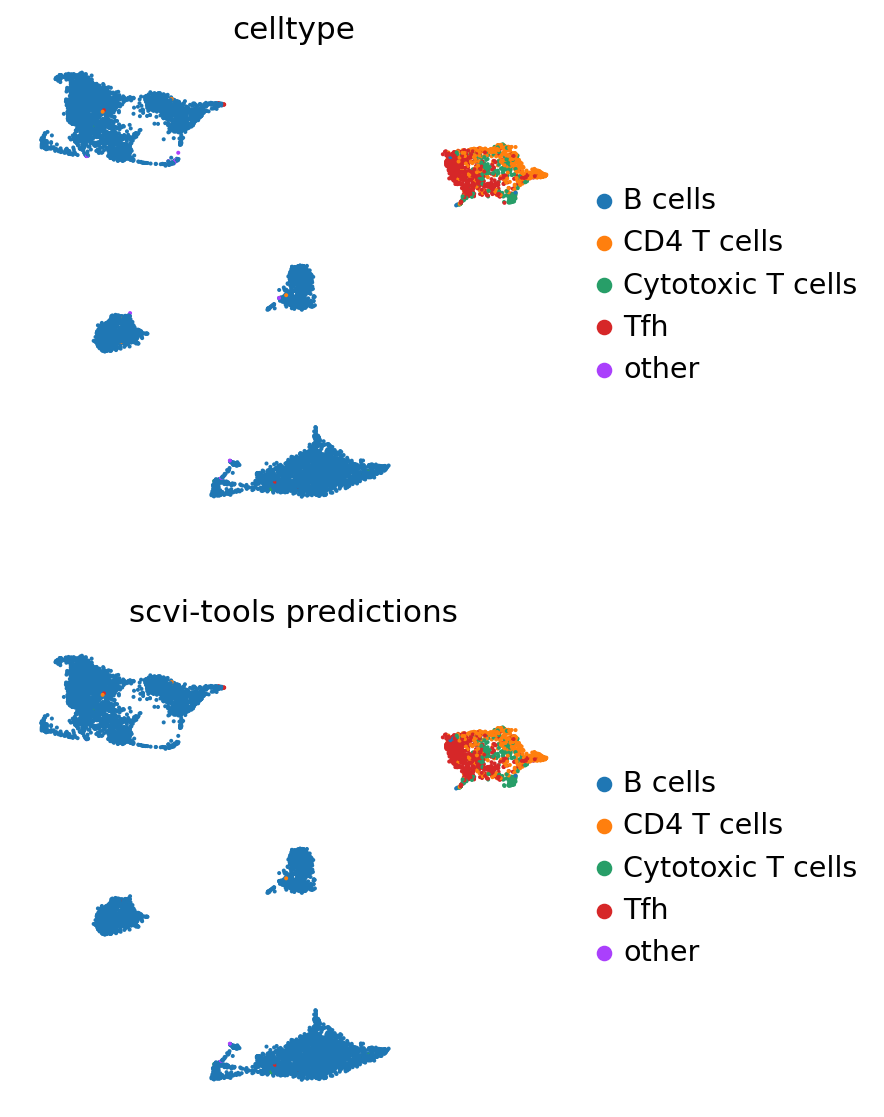

In [ ]:
bdata.obs["scvi-tools predictions"] = predictions.idxmax(axis=1).values

sc.pl.umap(
    bdata,
    color=["celltype", "scvi-tools predictions"],
    frameon=False,
    ncols=1
)

In [ ]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/CellAssign Data /'
bdata.obs.to_csv(dir + 'CellAssign_FollicularLymphoma_predictions.csv')